<a href="https://www.kaggle.com/ranjeetshrivastav/tps-may-tuning-ann-using-randomizedsearchcv?scriptVersionId=88455198" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-may-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-may-2021/train.csv
/kaggle/input/tabular-playground-series-may-2021/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv(r'../input/tabular-playground-series-may-2021/train.csv')
test = pd.read_csv(r'../input/tabular-playground-series-may-2021/test.csv')
sample_submission = pd.read_csv('../input/tabular-playground-series-may-2021/sample_submission.csv')

In [4]:
train.shape, test.shape

((100000, 52), (50000, 51))

In [5]:
train.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0,0,0,1,0,1,0,0,0,0,...,0,0,21,0,0,0,0,0,0,Class_2
1,1,0,0,0,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,2,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,13,2,0,Class_1
3,3,0,0,0,0,0,0,0,3,0,...,0,0,0,0,0,0,0,1,0,Class_4
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Class_2


* Drop **id** feature from both **train** & **test** datasets

In [6]:
train.drop('id',axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)

* reference :[https://www.kaggle.com/subinium/tps-may-categorical-eda](https://www.kaggle.com/subinium/tps-may-categorical-eda)

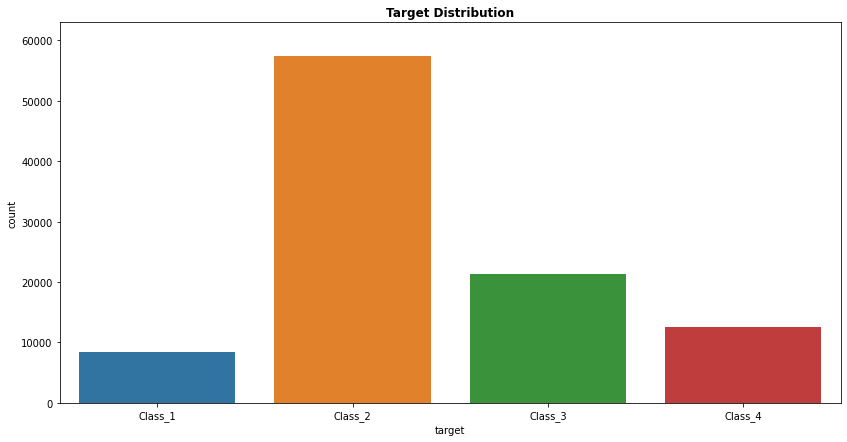

In [7]:
plt.figure(figsize=(14,7))
sns.countplot(x='target', data=train, order=sorted(train['target'].unique()))
plt.ylim(0, 63000)
plt.title('Target Distribution', weight='bold')
plt.show()

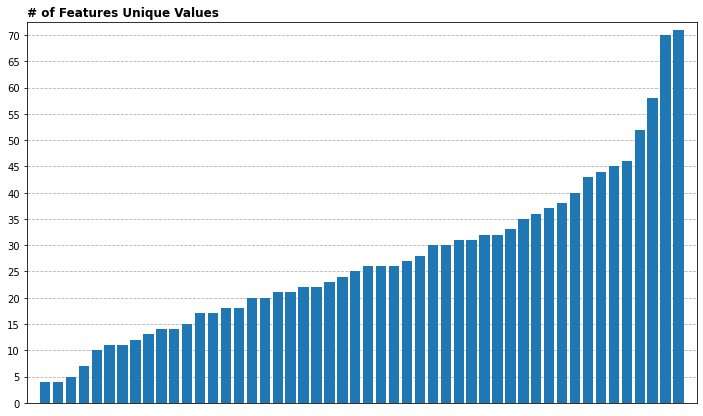

In [8]:
plt.figure(figsize=(12,7))

# x = [f'feature_{i}' for i in range(50)]
y = sorted([len(train[f'feature_{i}'].unique()) for i in range(50)])

plt.bar(range(50), y, zorder=10)
plt.xticks([])
plt.yticks(range(0, 80, 5))
plt.margins(0.02)

plt.title('# of Features Unique Values', loc='left', fontweight='bold')
plt.grid(axis='y', linestyle='--', zorder=5)
plt.show()

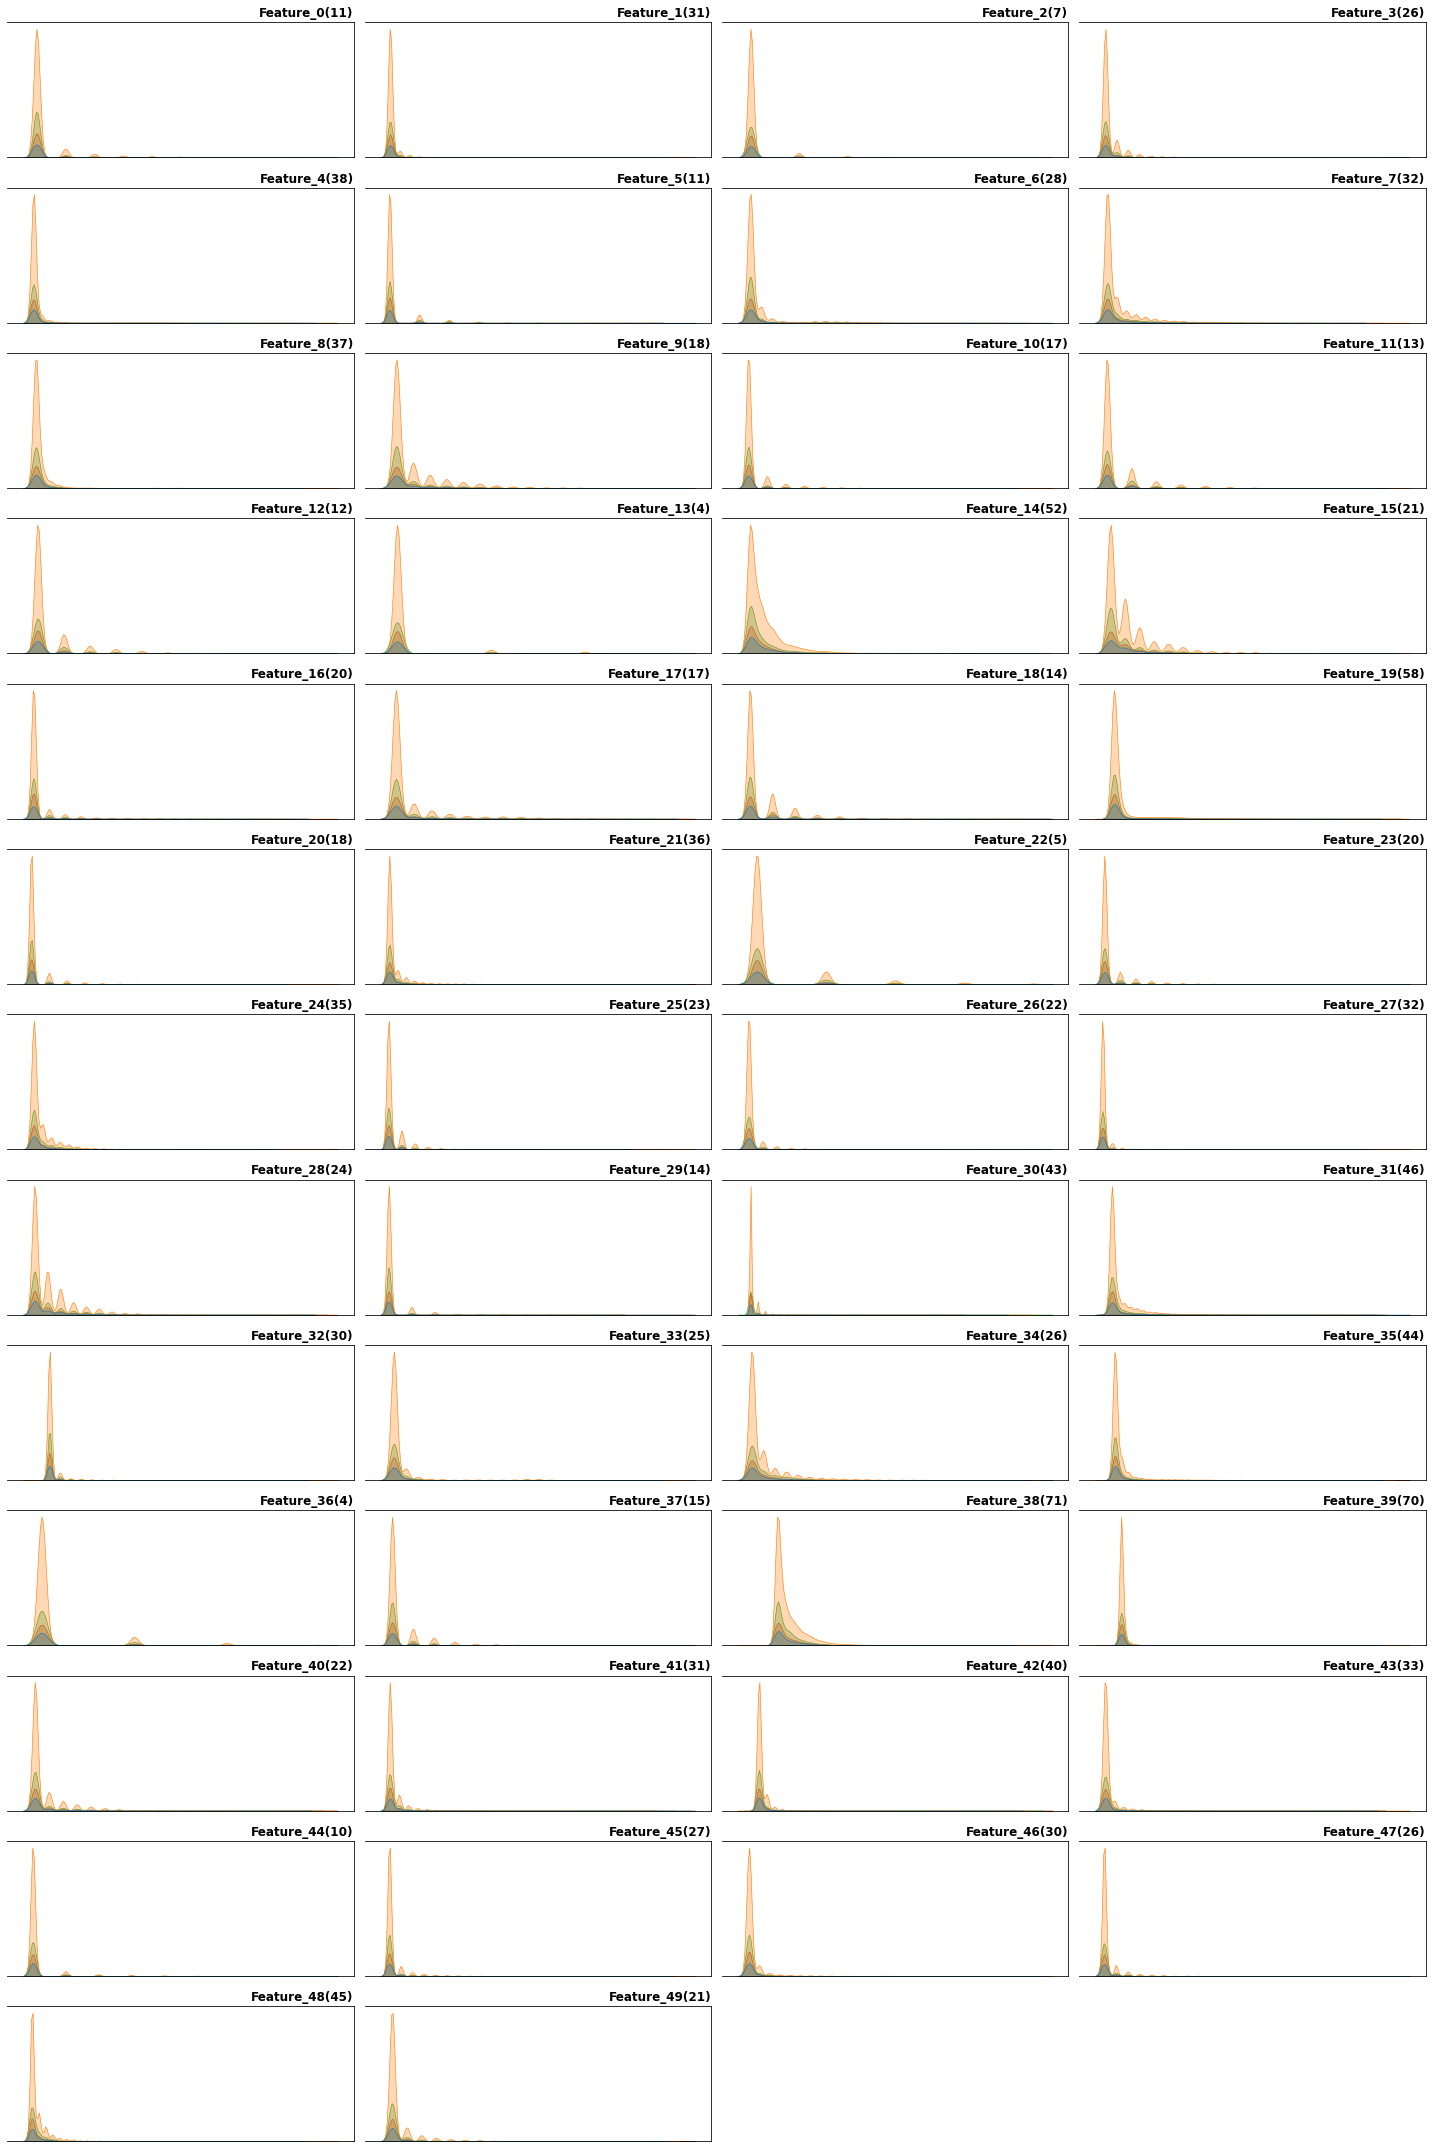

In [9]:
fig, axes = plt.subplots(13, 4, figsize=(20, 30))

target_order = sorted(train['target'].unique())
for idx, ax in zip(range(50), axes.flatten()):
    cnt = train[f'feature_{idx}'].value_counts().sort_index()
    sns.kdeplot(x=f'feature_{idx}', 
                hue='target', hue_order=target_order,
                data=train,
                alpha=0.3, 
                linewidth=0.6, fill=True,
                legend=False,
                ax=ax)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['left'].set_visible(False)
    cnt = len(train[f'feature_{idx}'].unique())
    ax.set_title(f'Feature_{idx}({cnt})', loc='right', weight='bold')

axes.flatten()[-1].axis('off')    
axes.flatten()[-2].axis('off')

fig.tight_layout()
plt.show()

### Model building

In [10]:
X = train.drop('target',axis=1)
y = train['target']

In [11]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, stratify=dummy_y,test_size=0.25)

In [13]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
test = sc.fit_transform(test)

I define a function build_classifier to use the wrappers KerasClassifier. build_classifier creates and returns the Keras sequential model.
I am passing three arguments to the function:
* optimizer is the optimization technique we want to use for our neural network
* Kernel which is to set the kernel_initializer
* units is the no. of hidden nodes in the hidden layer

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [15]:
def build_classifier(optimizer,kernel, units):
    classifier = Sequential()
    #First Hidden Layer
    classifier.add(Dense(units=units, activation='relu', kernel_initializer=kernel, input_dim=X_train.shape[1]))
    classifier.add(Dropout(rate=0.3))
    #Second  Hidden Layer
    classifier.add(Dense(units=units, activation='relu', kernel_initializer=kernel))
    classifier.add(Dropout(0.2))
    # Adding the third hidden layer
    classifier.add(Dense(units = units, kernel_initializer=kernel,activation='relu'))
    classifier.add(Dropout(0.2))
    #Output Layer
    classifier.add(Dense(4, activation='softmax', kernel_initializer=kernel))
    #Compiling the neural network
    classifier.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics =['accuracy'])
    return classifier

passing build_classifier function to the build_fn argument when constructing the **KerasClassifier** class.

In [16]:
from keras.wrappers.scikit_learn import KerasClassifier
classifier = KerasClassifier(build_fn=build_classifier)

I am tuning the neural network using the **RandomizedSearchCV**. The hyperparameters we want to tune are:
* batch_size
* epochs
* optimizer — this will pass an argument while building the neural network to function build_classifier
* kernel_initializer — this will pass an argument while building the neural network to function build_classifier
* units — this will pass as an argument while building the neural network to function build_classifier

In [17]:
from sklearn.model_selection import RandomizedSearchCV
parameters ={'batch_size':(32,64,128),
            'epochs':(10,20,25),
            'optimizer':('adam','SGD'),
            'kernel':('he_uniform','glorot_uniform'),
            'units':[(20), (40, 20), (45, 30, 15)]}
random_search= RandomizedSearchCV(estimator=classifier, param_distributions=parameters,cv=5)

In [18]:
random_result = random_search.fit(X_train, y_train)

Epoch 1/25
469/469 [==============================] - 2s 2ms/step - loss: 1.5164 - accuracy: 0.4466
Epoch 2/25
469/469 [==============================] - 1s 2ms/step - loss: 1.1889 - accuracy: 0.5631
Epoch 3/25
469/469 [==============================] - 1s 2ms/step - loss: 1.1477 - accuracy: 0.5719
Epoch 4/25
469/469 [==============================] - 2s 3ms/step - loss: 1.1410 - accuracy: 0.5707
Epoch 5/25
469/469 [==============================] - 1s 2ms/step - loss: 1.1307 - accuracy: 0.5731
Epoch 6/25
469/469 [==============================] - 1s 2ms/step - loss: 1.1247 - accuracy: 0.5752
Epoch 7/25
469/469 [==============================] - 1s 2ms/step - loss: 1.1252 - accuracy: 0.5732
Epoch 8/25
469/469 [==============================] - 1s 2ms/step - loss: 1.1228 - accuracy: 0.5752
Epoch 9/25
469/469 [==============================] - 1s 2ms/step - loss: 1.1205 - accuracy: 0.5753
Epoch 10/25
469/469 [==============================] - 1s 2ms/step - loss: 1.1202 - accuracy: 0.5741

In [19]:
print('Random Best score',random_result.best_score_)
print('Random Best params',random_result.best_params_)
print('Random execution time',random_result.refit_time_)

Random Best score 0.5750266671180725
Random Best params {'units': 20, 'optimizer': 'SGD', 'kernel': 'glorot_uniform', 'epochs': 25, 'batch_size': 32}
Random execution time 124.89645576477051


In [20]:
sample_submission[['Class_1','Class_2', 'Class_3', 'Class_4']] = random_search.predict_proba(test)
sample_submission.to_csv(f'submission.csv',index=False)

In [21]:
"""model = Sequential()
# Adding the input layer and the first hidden layer
model.add(Dense(units = 20, kernel_initializer='he_uniform', activation='relu', input_dim=X_train.shape[1]))
#model.add(BatchNormalization())
model.add(Dropout(0.3))
# Adding the second hidden layer
model.add(Dense(units = 20, kernel_initializer='he_uniform',activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.2))
# Adding the third hidden layer
model.add(Dense(units = 20, kernel_initializer='he_uniform',activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units=4,activation='softmax'))"""

"model = Sequential()\n# Adding the input layer and the first hidden layer\nmodel.add(Dense(units = 20, kernel_initializer='he_uniform', activation='relu', input_dim=X_train.shape[1]))\n#model.add(BatchNormalization())\nmodel.add(Dropout(0.3))\n# Adding the second hidden layer\nmodel.add(Dense(units = 20, kernel_initializer='he_uniform',activation='relu'))\n#model.add(BatchNormalization())\nmodel.add(Dropout(0.2))\n# Adding the third hidden layer\nmodel.add(Dense(units = 20, kernel_initializer='he_uniform',activation='relu'))\n#model.add(BatchNormalization())\nmodel.add(Dropout(0.2))\n# Adding the output layer\nmodel.add(Dense(units=4,activation='softmax'))"

In [22]:
#model.summary()

In [23]:
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [24]:
#model_history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=128)

In [25]:
"""# plot the loss
plt.plot(model_history.history['loss'], label='train loss')
plt.plot(model_history.history['val_loss'], label='val loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()"""

"# plot the loss\nplt.plot(model_history.history['loss'], label='train loss')\nplt.plot(model_history.history['val_loss'], label='val loss')\nplt.title('model loss')\nplt.ylabel('loss')\nplt.xlabel('epoch')\nplt.legend()\nplt.show()"

In [26]:
"""# plot the accuracy
plt.plot(model_history.history['accuracy'], label='train acc')
plt.plot(model_history.history['val_accuracy'], label='val acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()"""

"# plot the accuracy\nplt.plot(model_history.history['accuracy'], label='train acc')\nplt.plot(model_history.history['val_accuracy'], label='val acc')\nplt.title('model accuracy')\nplt.ylabel('accuracy')\nplt.xlabel('epoch')\nplt.legend()\nplt.show()"